In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics


%matplotlib inline

# Load the Data

In [3]:
df = pd.read_csv("cleaned_plyear_data.csv")

In [4]:
df

,Team,Position,Height,Age,Appearances,Goals,Assists,Yellow_Cards,Second_Yellow_Cards,Red_Cards,Goals_Conceded,Clean_Sheets,Minutes_Played,Days_Injured,Games_Injured,Award,Current_Value,Highest_Value,Position_Encoded,Winger
0,Manchester United,Goalkeeper,196.000000,30.0,15,0.000000,0.000000,0.069018,0.0,0.000000,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0
1,Manchester United,Goalkeeper,188.000000,37.0,4,0.000000,0.000000,0.000000,0.0,0.000000,0.616438,0.924658,292,697,84,4,600000,6000000,1,0
2,Manchester United,Defender Centre-Back,185.000000,31.0,8,0.000000,0.000000,0.216346,0.0,0.000000,0.000000,0.000000,416,932,169,7,2000000,20000000,2,0
3,Manchester United,Defender Centre-Back,186.000000,21.0,34,0.000000,0.000000,0.130529,0.0,0.000000,0.000000,0.000000,2758,47,13,0,2000000,2000000,2,0
4,Manchester United,Defender Left-Back,169.000000,23.0,89,0.012619,0.063096,0.227145,0.0,0.000000,0.000000,0.000000,7132,182,15,3,22000000,22000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10298,Western Sydney Wanderers,Attack-RightWinger,181.240353,20.0,16,0.175953,0.087977,0.263930,0.0,0.000000,0.000000,0.000000,1023,0,0,0,75000,75000,4,1
10299,Western Sydney Wanderers,Attack Centre-Forward,190.000000,24.0,26,0.372671,0.186335,0.186335,0.0,0.000000,0.000000,0.000000,1449,102,18,0,300000,300000,4,0
10300,Western Sydney Wanderers,Attack Centre-Forward,181.240353,19.0,20,0.375000,0.000000,0.187500,0.0,0.000000,0.000000,0.000000,960,0,0,0,50000,50000,4,0
10301,Western Sydney Wanderers,Attack Centre-Forward,181.240353,20.0,17,0.312139,0.104046,0.000000,0.0,0.104046,0.000000,0.000000,865,0,0,0,50000,50000,4,0


# Aggregat
Aggregating categorical feature

In [6]:
categorical_features = df.select_dtypes(include=['object']).columns
categorical_features

Index(['Team', 'Position'], dtype='object')

# One hot coding

In [8]:
df = pd.get_dummies(df, columns=categorical_features)

In [9]:
df.shape

(10303, 405)

# Split the players to 3 categories by percentiles

In [11]:
#p30 = df['Current_Value'].quantile(0.30)
p60 = df['Current_Value'].quantile(0.60)
p90 = df['Current_Value'].quantile(0.90)

# Function to categorize prices
def categorize_Current_Value(Current_Value):
    
    if Current_Value < p60:
        return 'good player'
    elif Current_Value < p90:
        return 'Excellent player'
    else:
        return 'legend'

# Apply the function to create a new column
df['categorize_Current_Value'] = df['Current_Value'].apply(categorize_Current_Value)

df.drop('Current_Value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['categorize_Current_Value'].value_counts())

categorize_Current_Value
good player         5798
Excellent player    3361
legend              1144
Name: count, dtype: int64


# encoder

In [13]:
encoder = LabelEncoder()
df['categorize_Current_Value'] = encoder.fit_transform(df['categorize_Current_Value'])  

# Feature selection

In [15]:
correlation = df.corr(numeric_only=True)
print(correlation['categorize_Current_Value'].sort_values(ascending=False))

categorize_Current_Value    1.000000
Highest_Value               0.250882
Team_Southampton FC         0.076884
Team_AS Monaco              0.071370
Team_Atalanta BC            0.062326
                              ...   
Team_Real Valladolid CF    -0.041331
Days_Injured               -0.041717
Games_Injured              -0.043376
Team_Elche CF              -0.047664
Age                        -0.079042
Name: categorize_Current_Value, Length: 405, dtype: float64


In [16]:
threshold = 0.07 
selected_features = correlation[abs(correlation['categorize_Current_Value']) > \
threshold]['categorize_Current_Value'].index
selected_features

Index(['Age', 'Highest_Value', 'Team_AS Monaco', 'Team_Southampton FC',
       'categorize_Current_Value'],
      dtype='object')

In [17]:
selected_features =['Age', 'Highest_Value', 'Team_AS Monaco', 'Team_Southampton FC',
       'categorize_Current_Value']

# Split data to train and test

In [19]:
X = df.drop(['categorize_Current_Value'], axis=1)
y = df['categorize_Current_Value']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Buliding the Model
Bulid aLogisticr Regression Model

In [21]:
KNN_model = KNeighborsClassifier()

In [22]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7,9,10]
}
grid_search = GridSearchCV(estimator=KNN_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

# Train the model

In [24]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 9, 10]},
             scoring='f1_macro', verbose=1)

In [25]:
grid_search.best_params_

{'n_neighbors': 5}

In [26]:
model = grid_search.best_estimator_

In [27]:
y_pred = model.predict(X_test_scaled)

In [28]:
base_model = round(df['categorize_Current_Value'].value_counts()[1]/df.shape[0]*100, 2)
base_model

56.27

# Test the model

In [78]:
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy",test_accuracy)

Test Accuracy 0.6933527413876759


# Evaluating the Model 

In [32]:
# our benchmark model
base_model = round(df['categorize_Current_Value'].value_counts()[1]/df.shape[0]*100, 2)
base_model

56.27

#### accuracy

In [80]:
y_pred_train = model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Train Accuracy",train_accuracy)

Train Accuracy 0.7921620965785003


In [35]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[410, 236,  46],
       [241, 894,  10],
       [ 88,  11, 125]], dtype=int64)

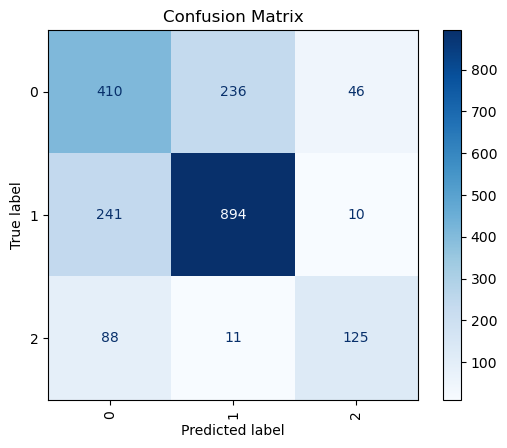

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [37]:
base_model = round(df['categorize_Current_Value'].value_counts()[1]/df.shape[0]*100, 2)
base_model

56.27

#### Precision

In [39]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.68


#### Recall

In [41]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.64


#### F1

In [43]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.66
